In [3]:
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.weightstats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

## Main Function

In [318]:
def AB_testing(meauretype, csv, Type = 'two-sided'):
    df = pd.read_csv(csv)
    if meauretype == 'rate':
        Test_groups = len(df)-1
        ### Bonferonni Correction for Multiple Testings
        alpha_overall = 0.05
        alpha_indiv = alpha_overall/Test_groups
        
        df['visit_rate'] = df['content_seen_user_count']/df['population_user_count']
        df['play_rate'] = df['content_play_user_count']/df['population_user_count']
        ### Sample Sizes
        group_sizes = df.groupby('IsHoldout')['population_user_count'].mean().reset_index()
        group_sizes.columns = ['Is_Holdout','Sample Sizes']
        group_sizes
        
        #### Plots for two metrics
        fig, axs = plt.subplots(1,2, sharey=False)
        plt.subplots_adjust(wspace = 0.5)
        sns.barplot(x='IsHoldout', y = 'visit_rate', data= df, ax=axs[0])
        sns.barplot(x='IsHoldout', y = 'play_rate', data= df, ax =axs[1])
        plt.show()
        
        ### P-value results
        Test_df = df[df['IsHoldout']!=1].reset_index(drop=True)
        Control_df = df[df['IsHoldout']==1]
        Pval_list = []
        for i in Test_df['IsHoldout']:
            ## Test for visit rate
            Test_data = Test_df[Test_df['IsHoldout']==i].reset_index(drop=True)
            count = np.array([Test_data['content_seen_user_count'][0],Control_df['content_seen_user_count'][0]])
            nobs = np.array([Test_data['population_user_count'][0],Control_df['population_user_count'][0]])
            stat, pval = proportions_ztest(count, nobs, alternative=Type)
            ## Test for Play rate
            count1 = np.array([Test_data['content_play_user_count'][0],Control_df['content_play_user_count'][0]])
            nobs1 = np.array([Test_data['population_user_count'][0],Control_df['population_user_count'][0]])
            stat1, pval1 = proportions_ztest(count1, nobs1, alternative=Type)
            if pval <= alpha_indiv:
                sig = 'Yes'
            else:
                sig = 'No'
            if pval1 <= alpha_indiv:
                sig1 = 'Yes'
            else:
                sig1 = 'No'
            Pval_list.append([i,pval,sig,pval1,sig1])
        Pval_df = pd.DataFrame(Pval_list,columns=['Testing_Group','p-Value (Visit Rate)','Significant?','p-Value (Play Rate)','Significant?'])        
              
    elif meauretype == 'continuous':
        ### Sample Sizes
        group_sizes = df.groupby('IsHoldout')['consumerId'].count().reset_index()
        group_sizes.columns=['Is_Holdout','Sample Sizes']
        
        ### Bar Plot
        listening_hrs = df.groupby('IsHoldout')['listening_time_hrs'].mean().reset_index()
        play_count = df.groupby('IsHoldout')['album_song_30s_play_count'].mean().reset_index()
        fig, axs = plt.subplots(1,2, sharey=False)
        plt.subplots_adjust(wspace = 0.5)
        sns.barplot(x='IsHoldout', y = 'listening_time_hrs', data= listening_hrs, ax=axs[0])
        sns.barplot(x='IsHoldout', y = 'album_song_30s_play_count', data= play_count, ax =axs[1])
        plt.show()
            
        ### Distribution Plot 
        for i in df['IsHoldout'].unique():
            f, axes = plt.subplots(2,2, figsize=(14, 7), sharex='col', sharey= False, gridspec_kw= {"height_ratios": (0.1, 1)})
            data = df[(df['IsHoldout']==i) & (df['listening_time_hrs']>0)]['listening_time_hrs'].rename(None)
            data_ajusted = data[data.between(data.quantile(.05), data.quantile(.95))] 

            mean = data_ajusted.mean()
            median = data_ajusted.median()
            mode = data_ajusted.mode().all()

            sns.boxplot(data_ajusted, ax = axes[0,0]).set(title = 'IsHoldout-'+str(i)+' '+'Distribution for listening_time_hrs')
            sns.distplot(data_ajusted, ax = axes[1,0], color = 'b').set(xlabel = 'Listening Time in Hours')

            axes[0,0].axvline(mean, color='r', linestyle='--')
            axes[0,0].axvline(median, color='m', linestyle=':')
            axes[0,0].axvline(mode, color='g', linestyle='-')
            axes[1,0].axvline(mean, color='r', linestyle='--')
            axes[1,0].axvline(median, color='m', linestyle=':')
            axes[1,0].axvline(mode, color='g', linestyle='-')
            axes[1,0].legend({'Mean: '+str(format(mean,'.2f')):mean,'Median: '+str(format(median,'.2f')):median,'Mode: '+str(format(mode,'.2f')):mode})

            data1 = df[(df['IsHoldout']==i) & (df['album_song_30s_play_count']>0)]['album_song_30s_play_count'].rename(None)
            data_ajusted1 = data1[data1.between(data1.quantile(.05), data1.quantile(.95))] 

            sns.boxplot(data_ajusted1, ax=axes[0,1]).set(title = 'IsHoldout-'+str(i)+' '+'Distribution for album_song_30s_play_count')
            sns.distplot(data_ajusted1, ax = axes[1,1], color = 'g').set(xlabel = 'Number of at least 30s play of the album song')

            mean1 = data_ajusted1.mean()
            median1 = data_ajusted1.median()
            mode1 = data_ajusted1.mode().all()

            axes[0,1].axvline(mean1, color='r', linestyle='--')
            axes[0,1].axvline(median1, color='m', linestyle=':')
            axes[0,1].axvline(mode1, color='g', linestyle='-')
            axes[1,1].axvline(mean1, color='r', linestyle='--')
            axes[1,1].axvline(median1, color='m', linestyle=':')
            axes[1,1].axvline(mode1, color='g', linestyle='-')
            axes[1,1].legend({'Mean: '+str(format(mean1,'.2f')):mean1,'Median: '+str(format(median1,'.2f')):median1,'Mode: '+str(format(mode1,'.2f')):mode1})

        ### Bonferonni Correction for Multiple Testings
        Test_groups = df['IsHoldout'].value_counts()
        n = len(Test_groups)-1 
        alpha_overall = 0.05
        alpha_indiv = alpha_overall/n
        
        ### P-value results
        Control_df = df[df['IsHoldout']==1].reset_index(drop=True)
        Test_df = df[df['IsHoldout']!=1].reset_index(drop=True)
        Pval_list = []
        for i in Test_df['IsHoldout'].unique():
            Test_data = Test_df[Test_df['IsHoldout']==i].reset_index(drop=True)
            ## T-Test for listening Hrs
            stats, pval, dfs = ttest_ind(Test_data['listening_time_hrs'],Control_df['listening_time_hrs'], alternative=Type)
            ## T-test for mean of 30s play count
            stats1, pval1, dfs1 = ttest_ind(Test_data['album_song_30s_play_count'],Control_df['album_song_30s_play_count'], alternative=Type)
            if pval <= alpha_indiv:
                sig = 'Yes'
            else:
                sig = 'No'
            if pval1 <= alpha_indiv:
                sig1 = 'Yes'
            else:
                sig1 = 'No'
            Pval_list.append([i,pval,sig,pval1,sig1])
        Pval_df = pd.DataFrame(Pval_list,columns=['Testing_Group','p-Value (listening_time_hrs)','Significant?','p-Value (album_song_30s_play_count)','Significant?'])
    

    else:
        return 'Please Specify your metric type as either "rate" or "continuous"'
    return display(group_sizes,Pval_df)
        

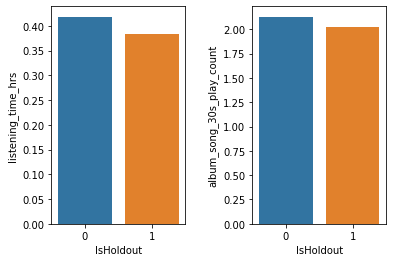

,Is_Holdout,Sample Sizes
0,0,5831240
1,1,303153


,Testing_Group,p-Value (listening_time_hrs),Significant?,p-Value (album_song_30s_play_count),Significant?
0,0,0.000001,Yes,0.033612,Yes


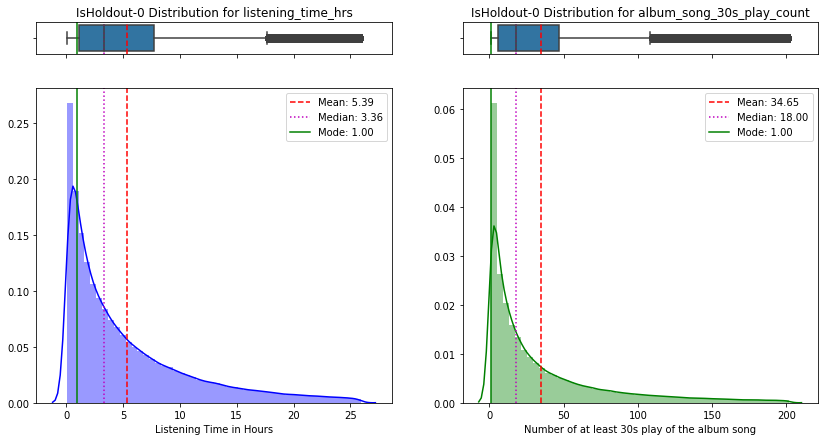

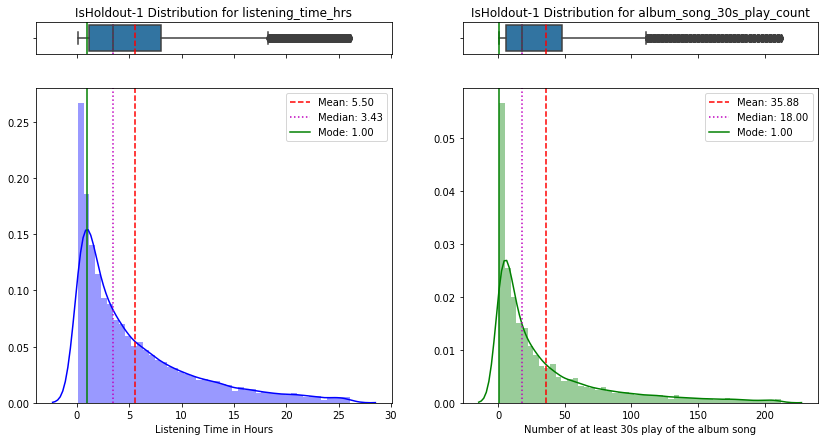

In [319]:
AB_testing('continuous','continuous_metrics.csv')

## For Rate Metrics

In [615]:
df_rate = pd.read_csv('rate_metrics.csv')
df_rate['visit_rate'] = df_rate['content_seen_user_count']/df_rate['population_user_count']
df_rate['play_rate'] = df_rate['content_play_user_count']/df_rate['population_user_count']

group_sizes = df_rate.groupby('IsHoldout')['population_user_count'].mean().reset_index()
group_sizes.columns = ['Is_Holdout','Sample Sizes']
group_sizes

,Is_Holdout,Sample Sizes
0,0,5831240
1,1,303154
2,2,623091


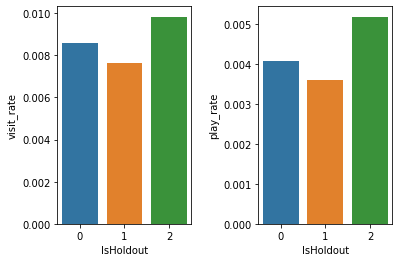

,Testing_Group,Sample Sizes
0,0,5831240
1,2,623091


In [597]:

#### Plots for two metrics
fig, axs = plt.subplots(1,2, sharey=False)
plt.subplots_adjust(wspace = 0.5)
sns.barplot(x='IsHoldout', y = 'visit_rate', data= df_rate, ax=axs[0])
sns.barplot(x='IsHoldout', y = 'play_rate', data= df_rate, ax =axs[1])
plt.show()
Test_group_sizes
Test_df = df_rate[df_rate['IsHoldout']!=1].reset_index(drop=True)


In [598]:
df_rate
Test_df = df_rate[df_rate['IsHoldout']!=1].reset_index(drop=True)
Test_df

,IsHoldout,population_user_count,banner_seen_user_count,content_seen_user_count,content_play_user_count,visit_rate,play_rate
0,0,5831240,117065,50144,23721,0.008599,0.004068
1,2,623091,10441,6128,3234,0.009835,0.005190


In [613]:
Control_df = df_rate[df_rate['IsHoldout']==1]
Pval_list = []
for i in Test_df['IsHoldout']:
    ## Test for visit rate
    Test_data = Test_df[Test_df['IsHoldout']==i].reset_index(drop=True)
    count = np.array([Test_data['content_seen_user_count'][0],Control_df['content_seen_user_count'][0]])
    nobs = np.array([Test_data['population_user_count'][0],Control_df['population_user_count'][0]])
    stat, pval = proportions_ztest(count, nobs)
    ## Test for Play rate
    count1 = np.array([Test_data['content_play_user_count'][0],Control_df['content_play_user_count'][0]])
    nobs1 = np.array([Test_data['population_user_count'][0],Control_df['population_user_count'][0]])
    stat1, pval1 = proportions_ztest(count1, nobs1)


    Pval_list.append([i,pval,pval1])
Pval_df = pd.DataFrame(Pval_list,columns=['Testing_Group','p-Value (Visit Rate)','p-Value (Play Rate)'])
Pval_df

,Testing_Group,p-Value (Visit Rate),p-Value (Play Rate)
0,0,1.010738e-08,6.457125e-05
1,2,5.407300e-26,4.334414e-26


In [567]:
###### Two sample proportion Test on Visit Rate
count = np.array([df_rate['content_seen_user_count'][1],df_rate['content_seen_user_count'][0]])
nobs = np.array([df_rate['population_user_count'][1],df_rate['population_user_count'][0]])
## Add Alternative
stat, pval = proportions_ztest(count, nobs)
'{0:0.9f}'.format(pval)

'0.000000010'

In [565]:
###### Two sample proportion Test on Play Rate
count = np.array([df_rate['content_play_user_count'][1],df_rate['content_play_user_count'][0]])
nobs = np.array([df_rate['population_user_count'][1],df_rate['population_user_count'][0]])
stat, pval = proportions_ztest(count, nobs)
'{0:0.9f}'.format(pval)

'0.000064571'

## For Continious Metrics

In [305]:
df = pd.read_csv('continuous_metrics.csv')

In [315]:
Test_groups = df['IsHoldout'].value_counts()
n = len(Test_groups)-1 

In [112]:
group_sizes = df.groupby('IsHoldout')['consumerId'].count().reset_index()

In [113]:
group_sizes.columns=['Is_Holdout','Sample Sizes']
group_sizes

,Is_Holdout,Sample Sizes
0,0,5831240
1,1,303153


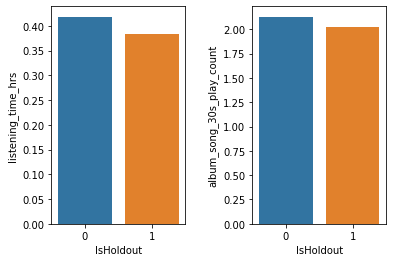

In [114]:
listening_hrs = df.groupby('IsHoldout')['listening_time_hrs'].mean().reset_index()
play_count = df.groupby('IsHoldout')['album_song_30s_play_count'].mean().reset_index()
fig, axs = plt.subplots(1,2, sharey=False)
plt.subplots_adjust(wspace = 0.5)
sns.barplot(x='IsHoldout', y = 'listening_time_hrs', data= listening_hrs, ax=axs[0])
sns.barplot(x='IsHoldout', y = 'album_song_30s_play_count', data= play_count, ax =axs[1])
plt.show()

In [115]:
### P-value results
Control_df = df[df['IsHoldout']==1].reset_index(drop=True)
#Control_data = Control_df.groupby('IsHoldout').mean().reset_index()
#Control_data['sample_size'] = len(Control_df)
Test_df = df[df['IsHoldout']!=1].reset_index(drop=True)
#Test_df1 = Test_df.groupby('IsHoldout').mean().reset_index()
#Test_df1['sample_size'] = Test_df.groupby('IsHoldout')['consumerId'].count()
Pval_list = []
for i in Test_df['IsHoldout'].unique():
    Test_data = Test_df[Test_df['IsHoldout']==i].reset_index(drop=True)
    ## T-Test for listening Hrs
    stats, pval, dfs = ttest_ind(Test_data['listening_time_hrs'],Control_df['listening_time_hrs'], alternative='two-sided')
    ## T-test for mean of 30s play count
    stats1, pval1, dfs1 = ttest_ind(Test_data['album_song_30s_play_count'],Control_df['album_song_30s_play_count'], alternative='two-sided')
    Pval_list.append([i,pval,pval1])
Pval_df = pd.DataFrame(Pval_list,columns=['Testing_Group','p-Value (listening_time_hrs)','p-Value (album_song_30s_play_count)'])
Pval_df

,Testing_Group,p-Value (listening_time_hrs),p-Value (album_song_30s_play_count)
0,0,0.000001,0.033612


In [123]:
## T-test for mean of lisitening Hours
test_x = df[df['IsHoldout']==0]['listening_time_hrs']
control_x = df[df['IsHoldout']==1]['listening_time_hrs']
stats, pval, dfs2 = ttest_ind(control_x,test_x, alternative='two-sided')
'{0:0.9f}'.format(pval)

'0.000001298'

In [124]:
## T-test for mean of 30s play count
test_x = df[df['IsHoldout']==0]['album_song_30s_play_count']
control_x = df[df['IsHoldout']==1]['album_song_30s_play_count']
stats, pval, dfs3 = ttest_ind(test_x,control_x, alternative='two-sided')
'{0:0.9f}'.format(pval)


'0.033611601'

In [211]:
test_play_ct_1_20 = [x for x in test_x if x >= 1 | x<= 20 ]
control_play_ct_1_20 = [x for x in control_x if x >= 1 | x<= 20 ]

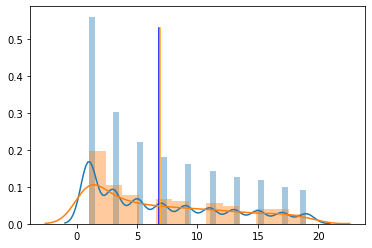

In [214]:
### distribution plot for 30s playcount in Control/Test Group
sns.distplot(test_play_ct_1_20)
plt.axvline(np.mean(test_play_ct_1_20), 0,0.9, color = 'blue')
sns.distplot(control_play_ct_1_20)
plt.axvline(np.mean(control_play_ct_1_20), 0,0.9,color = 'orange')

In [257]:
df = pd.read_csv('continuous_metrics.csv')

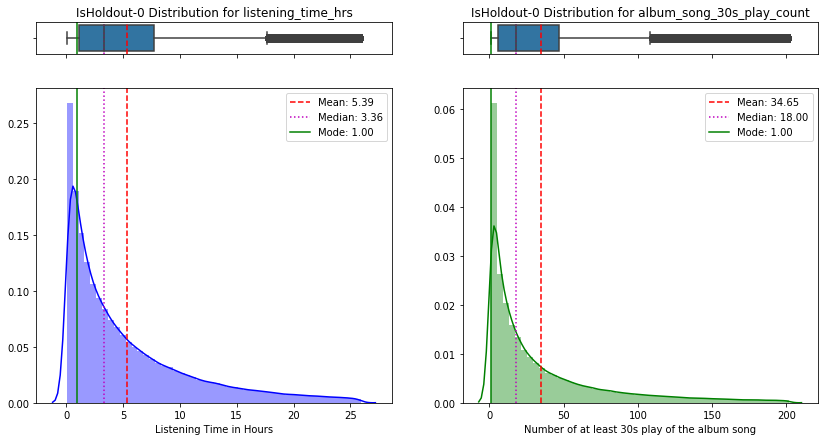

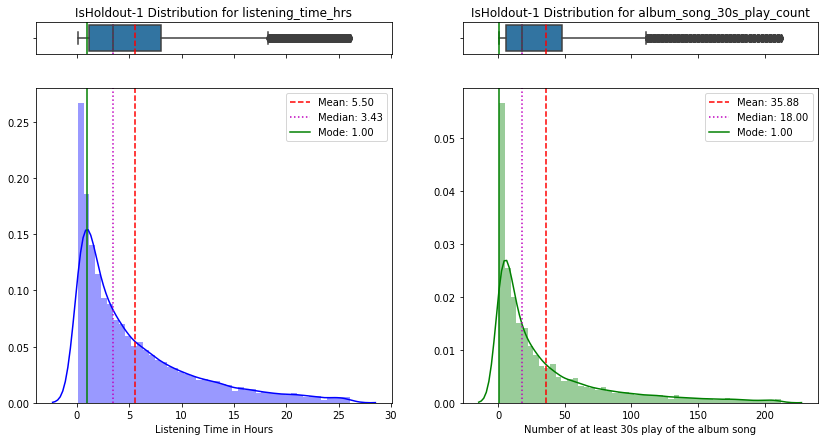

In [276]:
for i in df['IsHoldout'].unique():
    f, axes = plt.subplots(2,2, figsize=(14, 7), sharex='col', sharey= False, gridspec_kw= {"height_ratios": (0.1, 1)})
    data = df[(df['IsHoldout']==i) & (df['listening_time_hrs']>0)]['listening_time_hrs'].rename(None)
    data_ajusted = data[data.between(data.quantile(.05), data.quantile(.95))] 
    
    mean = data_ajusted.mean()
    median = data_ajusted.median()
    mode = data_ajusted.mode().all()
    
    sns.boxplot(data_ajusted, ax = axes[0,0]).set(title = 'IsHoldout-'+str(i)+' '+'Distribution for listening_time_hrs')
    sns.distplot(data_ajusted, ax = axes[1,0], color = 'b').set(xlabel = 'Listening Time in Hours')
    
    axes[0,0].axvline(mean, color='r', linestyle='--')
    axes[0,0].axvline(median, color='m', linestyle=':')
    axes[0,0].axvline(mode, color='g', linestyle='-')
    axes[1,0].axvline(mean, color='r', linestyle='--')
    axes[1,0].axvline(median, color='m', linestyle=':')
    axes[1,0].axvline(mode, color='g', linestyle='-')
    axes[1,0].legend({'Mean: '+str(format(mean,'.2f')):mean,'Median: '+str(format(median,'.2f')):median,'Mode: '+str(format(mode,'.2f')):mode})
   
    data1 = df[(df['IsHoldout']==i) & (df['album_song_30s_play_count']>0)]['album_song_30s_play_count'].rename(None)
    data_ajusted1 = data1[data1.between(data1.quantile(.05), data1.quantile(.95))] 
    
    sns.boxplot(data_ajusted1, ax=axes[0,1]).set(title = 'IsHoldout-'+str(i)+' '+'Distribution for album_song_30s_play_count')
    sns.distplot(data_ajusted1, ax = axes[1,1], color = 'g').set(xlabel = 'Number of at least 30s play of the album song')

    mean1 = data_ajusted1.mean()
    median1 = data_ajusted1.median()
    mode1 = data_ajusted1.mode().all()
    
    axes[0,1].axvline(mean1, color='r', linestyle='--')
    axes[0,1].axvline(median1, color='m', linestyle=':')
    axes[0,1].axvline(mode1, color='g', linestyle='-')
    axes[1,1].axvline(mean1, color='r', linestyle='--')
    axes[1,1].axvline(median1, color='m', linestyle=':')
    axes[1,1].axvline(mode1, color='g', linestyle='-')
    axes[1,1].legend({'Mean: '+str(format(mean1,'.2f')):mean1,'Median: '+str(format(median1,'.2f')):median1,'Mode: '+str(format(mode1,'.2f')):mode1})
 